Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [9]:
from random import random, seed
from itertools import product
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, set `REPRODUCIBILIY` to `True`

In [10]:
# Instance 1
#UNIVERSE_SIZE = 100
#NUM_SETS = 10
#DENSITY = 0.2

# Instance 2
#UNIVERSE_SIZE = 1_000
#NUM_SETS = 100
#DENSITY = 0.2

#Instance 3
UNIVERSE_SIZE = 10_000
NUM_SETS = 1000
DENSITY = 0.2

#Instance 4
#UNIVERSE_SIZE = 100_000
#NUM_SETS = 10_000
#DENSITY = 0.1

#Instance 5
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.2

# Instance 6
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3

N_STEPS = 5000

#Settings
REPRODUCIBILIY = False



rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
if REPRODUCIBILIY:
    random_gen = rng
else:
    random_gen = np.random



In [11]:
# DON'T EDIT THESE LINES!
SETS = random_gen.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        if REPRODUCIBILIY:
            SETS[random_gen.integers(NUM_SETS), s] = True
        else:
            SETS[random_gen.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

# Define the universe (set of required elements)
universe = set(range(UNIVERSE_SIZE))  # Set of all required elements

## Helper Functions

In [12]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

Solution

In [13]:
def tweak(solution:np.ndarray)->np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0,NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

In [14]:
def fitness(solution:np.ndarray):
    return (valid(solution),-cost(solution))

In [15]:
# Define the simulated annealing function
used_simulated_annealing=0
def simulated_annealing(f_cur_sol: np.ndarray, f_tweaked_sol: np.ndarray, temperature: np.float64) -> np.float64:
    worse_p = np.exp((f_tweaked_sol[1] - f_cur_sol[1]) / temperature)  # Use cost for decision
    is_accept = random_gen.random() <= worse_p
    if is_accept:
        global used_simulated_annealing
        used_simulated_annealing+=1
    return is_accept


def multiple_mutation_tweak(solution:np.ndarray)->np.ndarray:
    for _ in range(5):
        mask = rng.random(NUM_SETS) < 0.005 ## 0.5% of the elements will be flipped
        new_sol = np.logical_xor(solution,mask)
        if valid(new_sol):
            return new_sol
    return new_sol


## Hill Climbing with simulated annealing and multi tweaks
Gives priority to improving the current solution, accepts worse solutions (simulated annealing) as temperature increases. It also uses multi tweaks.
Since the last test instances (with 5000 steps) keep improving the current solution, the probability of using simulated annealing  is low.

  0%|          | 0/5000 [00:00<?, ?it/s]

ic| "Best solution found:": 'Best solution found:'
    best_solution: (np.True_, np.float64(-426193.1411046953))
ic| history.index(best_solution): 4964
    best_solution: (np.True_, np.float64(-426193.1411046953))


Accepted worse solution (simulated annealing): 98 times


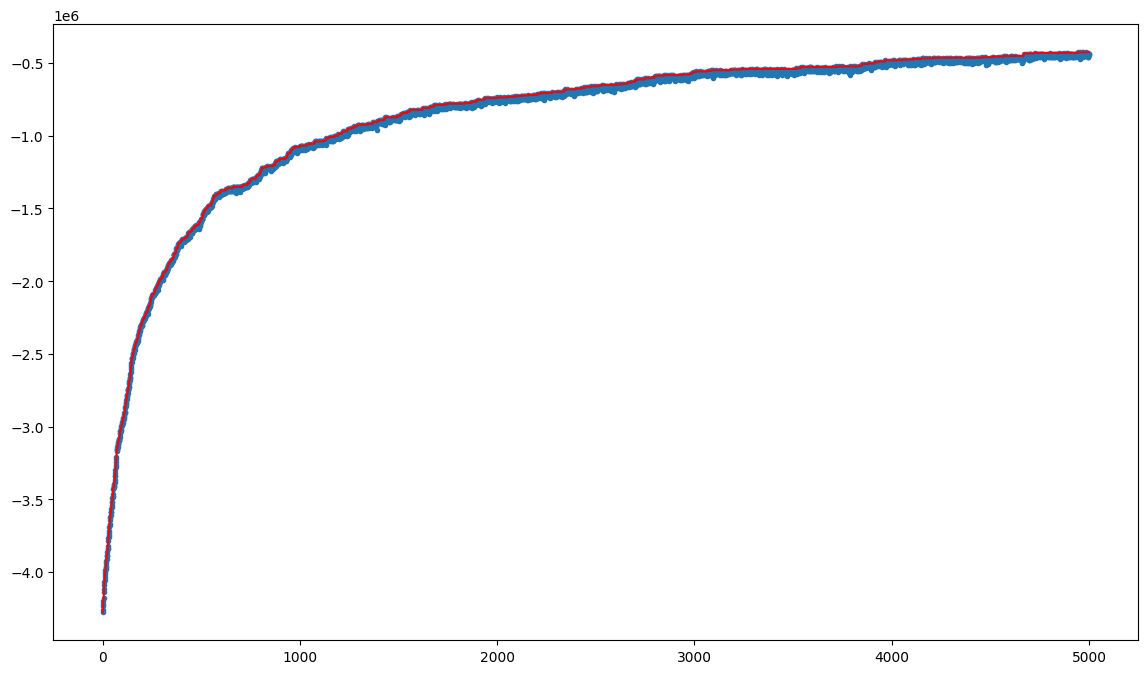

In [16]:
# Initialize variables
used_simulated_annealing = 0
solution = rng.random(NUM_SETS) < 1 #Start with a valid solution (edge case first configurations)
solution_fitness = fitness(solution)
history = [solution_fitness] if solution_fitness[0] else []
best_solution = solution_fitness
STARTING_VALUE_TEMP = 1 
temperature = STARTING_VALUE_TEMP


INC_VALUE = 20

# Simulated annealing loop
ic.disable()
for steps in tqdm(range(N_STEPS)):
    new_solution = multiple_mutation_tweak(solution)  # Use multiple_tweak
    f_newsol = fitness(new_solution)
    history.append(f_newsol)

    if (f_newsol > solution_fitness) or ( f_newsol[0] and simulated_annealing(solution_fitness,f_newsol,temperature)):  # Only accept if the solution is better or simulated annealing (since first solution is valid no need to check for validity)
        ic("accepted", f_newsol)
        solution = new_solution
        if (best_solution[1] < f_newsol[1]):
            best_solution = f_newsol
        solution_fitness = fitness(solution)
        temperature = STARTING_VALUE_TEMP  # Reset temperature
    else:
        # Here we would handle what to do if the new solution is invalid
        # Since we only accept valid solutions, we can ignore this case for now.
        temperature += INC_VALUE  # Increase temperature if not accepted

ic.enable()
print("Accepted worse solution (simulated annealing):", used_simulated_annealing, "times")
ic("Best solution found:", best_solution)
ic(history.index(best_solution),best_solution)


# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    [max(history[:i + 1], key=lambda x: x[1])[1] for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), [value for _, value in history], marker=".")
plt.show()

